# User Churn Prediction




## Outline


* [Part 1: Data Exploration](#Part-1:-Data-Exploration)
* [Part 2: Feature Preprocessing](#Part-2:-Feature-Preprocessing)
* [Part 3: Model Training and Results Evaluation](#Part-3:-Model-Training-and-Result-Evaluation)
* [Part 4: Feature Importance](#Part-4:-Feature-Selection)

# Part 0: Setup Google Drive Environment

In [0]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
link = 'https://drive.google.com/open?id=1tf2neoLxJDTQtiVtXhL3OOJCJRDvE8KN'
fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) 
file.GetContentFile('churn.csv')  

# Part 1: Data Exploration

### Part 1.1: Understand the Raw Dataset

In [0]:
import warnings 
import pandas as pd
import numpy as np
warnings.filterwarnings('ignore')
churn_df = pd.read_csv('churn.csv')
churn_df.head()

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [0]:
print ("Num of entries: " + str(churn_df.shape[0])) 
print ("Num of features: " + str(churn_df.shape[1])) 

Num of entries: 5000
Num of features: 21


### Part 1.2: Data cleaning

In [0]:
#data cleaning#1: missing value
churn_df.isnull().sum()
#pd.isnull(churn_df).any(axis=0)
#churn_df[pd.isnull(churn_df).any(axis=1)]

state                            0
account_length                   0
area_code                        0
phone_number                     0
intl_plan                        0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churned                          0
dtype: int64

In [0]:
#data cleaning#2: format checking
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
state                            5000 non-null object
account_length                   5000 non-null int64
area_code                        5000 non-null int64
phone_number                     5000 non-null object
intl_plan                        5000 non-null object
voice_mail_plan                  5000 non-null object
number_vmail_messages            5000 non-null int64
total_day_minutes                5000 non-null float64
total_day_calls                  5000 non-null int64
total_day_charge                 5000 non-null float64
total_eve_minutes                5000 non-null float64
total_eve_calls                  5000 non-null int64
total_eve_charge                 5000 non-null float64
total_night_minutes              5000 non-null float64
total_night_calls                5000 non-null int64
total_night_charge               5000 non-null float64
total_intl_minutes           

In [0]:
#data cleaning#3: logical mistake--duplication
churn_df[churn_df.duplicated()]

,state,account_length,area_code,phone_number,intl_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churned


In [0]:
#data cleaning#3: logical mistake--unreasonable value
churn_df['intl_plan'][0]
churn_df['churned'][0]
churn_df['voice_mail_plan'][0]

' yes'

In [0]:
# remove the heading and trailing whitespaces
churn_df['voice_mail_plan'] = churn_df['voice_mail_plan'].apply(lambda x: x.strip())
churn_df['intl_plan'] = churn_df['intl_plan'].apply(lambda x: x.strip())
churn_df['churned'] = churn_df['churned'].apply(lambda x: x.strip())

In [0]:
# check the categorical feature after manipulation
churn_df['voice_mail_plan'][0]

'yes'

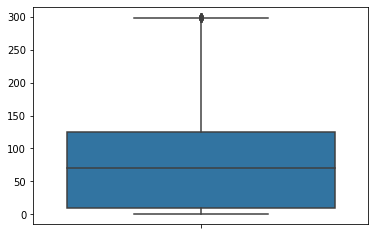

In [0]:
#data cleaning#3: logical mistake--outlier
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns 

def iqr_outlier_rm(dt_input):
  lq,uq=np.percentile(dt_input,[25,75])
  lower_l=lq - 1.5*(uq-lq)
  upper_l=uq + 1.5*(uq-lq)
  return dt_input[(dt_input >=lower_l)&(dt_input<=upper_l)]
  
dt_churn=iqr_outlier_rm(churn_df[["account_length", "number_vmail_messages", "total_day_minutes",
                    "total_day_calls", "total_day_charge", "total_eve_minutes",
                    "total_eve_calls", "total_eve_charge", "total_night_minutes",
                    "total_night_calls", "total_intl_minutes", "total_intl_calls",
                    "total_intl_charge"]])
sns.boxplot(dt_churn,orient='v')

In [0]:
#data cleaning#4: remove unnecessary features--based on common sense
to_drop = ['area_code','phone_number']
churn_1st_drop = churn_df.drop(to_drop, axis=1)

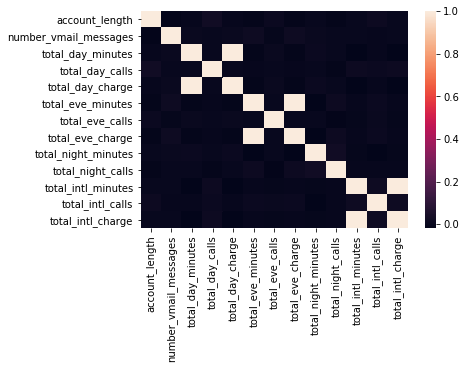

In [0]:
#data cleaning#4: remove unnecessary features--based on correlation between all features
corr = churn_df[["account_length", "number_vmail_messages", "total_day_minutes",
                    "total_day_calls", "total_day_charge", "total_eve_minutes",
                    "total_eve_calls", "total_eve_charge", "total_night_minutes",
                    "total_night_calls", "total_intl_minutes", "total_intl_calls",
                    "total_intl_charge"]].corr()
sns.heatmap(corr)

In [0]:
#data cleaning#4: remove unnecessary features--based on correlation between all features
to_drop = ['total_day_charge','total_eve_charge','total_intl_charge']
churn_2nd_drop = churn_1st_drop.drop(to_drop, axis=1)

In [0]:
print ("Num of entries: " + str(churn_2nd_drop.shape[0])) 
print ("Num of features: " + str(churn_2nd_drop.shape[1])) 

Num of entries: 5000
Num of features: 16


# Part 2: Feature Preprocessing

In [0]:
# Get ground truth data
y = np.where(churn_2nd_drop['churned'] == 'True.',1,0)
to_drop = ['churned']
churn_3rd_drop= churn_2nd_drop.drop(to_drop, axis=1)
# converte'yes' and 'no' to boolean values
yes_no_cols = ["intl_plan","voice_mail_plan"]
churn_3rd_drop[yes_no_cols] = churn_3rd_drop[yes_no_cols] == 'yes'
#sklearn.preprocessing.OneHotEncoder
churn_final = pd.get_dummies(churn_3rd_drop, columns=['state'])
X = churn_final
X.info()

In [0]:
# check the propotion of y = 1
print ("the proportion of churn (%) : " + str(y.sum() / y.shape * 100))
print(y.sum() / y.shape * 100)
print (y.shape)
print (y.sum())

the proportion of churn (%) : [14.14]
[14.14]
(5000,)
707


# Part 3: Model Training and Result Evaluation

### Part 3.1: Split dataset

In [0]:
from sklearn import model_selection

# Reserve 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)
print('training data has %d observation with %d features'% X_train.shape)
print('test data has %d observation with %d features'% X_test.shape)

training data has 4000 observation with 65 features
test data has 1000 observation with 65 features


In [0]:
#Standarized the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)

### Part 3.2: Model Training and Selection

In [0]:
#@title build models 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 

# Logistic Regression
classifier_logistic = LogisticRegression()

# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()

# SVM
classifier_SVC = SVC()

# Random Forest
classifier_RF = RandomForestClassifier()

In [0]:
# Train the model
classifier_logistic.fit(X_train, y_train)
classifier_logistic.predict(X_test)
classifier_logistic.score(X_test, y_test)

0.86

In [0]:
# Use 10-fold Cross Validation to get the accuracy for different models
model_names = ['Logistic Regression','KNN','Random Forest','SVM']
model_list = [classifier_logistic, classifier_KNN, classifier_RF, classifier_SVC]
count = 0

for classifier in model_list:
    cv_score = model_selection.cross_val_score(classifier, X_train, y_train, cv=10)
    print(cv_score)
    print('Model accuracy of %s is: %.3f'%(model_names[count],cv_score.mean()))
    count += 1

[0.8725 0.875  0.8575 0.845  0.88   0.845  0.88   0.855  0.885  0.86  ]
Model accuracy of Logistic Regression is: 0.865
[0.8625 0.875  0.8675 0.8475 0.875  0.87   0.865  0.855  0.8675 0.87  ]
Model accuracy of KNN is: 0.865
[0.95   0.9475 0.93   0.925  0.935  0.9275 0.955  0.93   0.955  0.9525]
Model accuracy of Random Forest is: 0.941
[0.8675 0.8675 0.8675 0.855  0.875  0.8625 0.8775 0.8625 0.8625 0.8775]
Model accuracy of SVM is: 0.868


###Part 3.3: Use Grid Search to Find Optimal Hyperparameters

In [0]:
from sklearn.model_selection import GridSearchCV 

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

#### Part 3.3.1: Find Optimal Hyperparameters: LogisticRegression

In [0]:
# Possible hyperparamter options for Logistic Regression Regularization 
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(0.01, 0.1, 1)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=10)
Grid_LR.fit(X_train, y_train)
print_grid_search_metrics(Grid_LR)
best_LR_model = Grid_LR.best_estimator_

Best score: 0.866
Best parameters set:
	C: 0.01
	penalty: 'l2'


#### Part 3.3.2: Find Optimal Hyperparameters: KNN

In [0]:
# Possible hyperparamter options for KNN --choose the best k
parameters = {
    'n_neighbors':[1,10,100] 
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=10)
Grid_KNN.fit(X_train, y_train)
print_grid_search_metrics(Grid_KNN)
best_KNN_model = Grid_KNN.best_estimator_

Best score: 0.862
Best parameters set:
	n_neighbors: 10


#### Part 3.3.3: Find Optimal Hyperparameters: Random Forest



In [0]:
# Possible hyperparamter options for Random Forest--choose the best number of trees
parameters = {
    'n_estimators' : [5,10,50,80,100]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=10)
Grid_RF.fit(X_train, y_train)
print_grid_search_metrics(Grid_RF)
best_RF_model = Grid_RF.best_estimator_

Best score: 0.943
Best parameters set:
	n_estimators: 100


#### Part 3.3.4: Find Optimal Hyperparameters: SVM

In [0]:
parameters = {'gamma': [0.01, 0.1, 1],
                     'C': [0.01, 0.1, 1]}                   
Grid_SVM = GridSearchCV(classifier_SVC,parameters, cv=10)
Grid_SVM.fit(X_train, y_train)
print_grid_search_metrics(Grid_SVM)
best_SVM_model = Grid_SVM.best_estimator_

Best score: 0.865
Best parameters set:
	C: 1
	gamma: 0.01


### Part 3.4: Model Evaluation - Confusion Matrix (Precision, Recall, Accuracy)

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

Random Forest
Accuracy is: 0.933
precision is: 0.968
recall is: 0.584


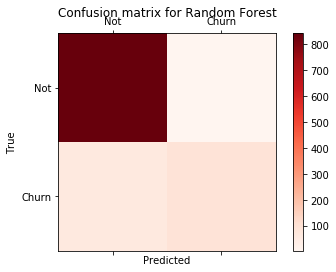

Logistic Regression
Accuracy is: 0.857
precision is: 0.657
recall is: 0.149


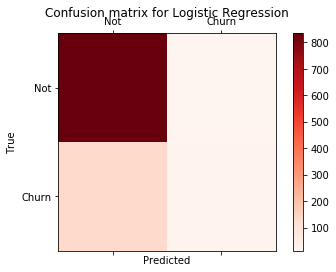

KNN
Accuracy is: 0.846
precision is: 0.500
recall is: 0.006


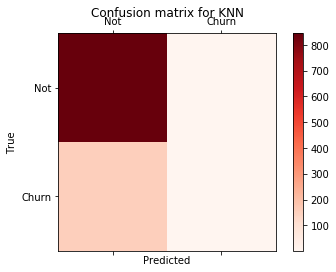

SVM
Accuracy is: 0.850
precision is: 0.750
recall is: 0.039


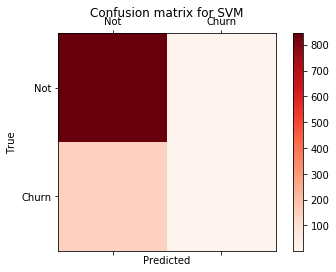

In [0]:
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Random Forest", confusion_matrix(y_test,best_RF_model.predict(X_test))),
    ("Logistic Regression", confusion_matrix(y_test,best_LR_model.predict(X_test))),
    ("KNN", confusion_matrix(y_test,best_KNN_model.predict(X_test))),
    ("SVM", confusion_matrix(y_test,best_SVM_model.predict(X_test)))
]

draw_confusion_matrices(confusion_matrices)

### Part 3.4: Model Evaluation - ROC & AUC

RandomForestClassifier, KNeighborsClassifier and LogisticRegression have predict_prob() function 

#### Part 3.4.1: ROC of RF Model

In [0]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Random Forest
y_pred_rf = best_RF_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

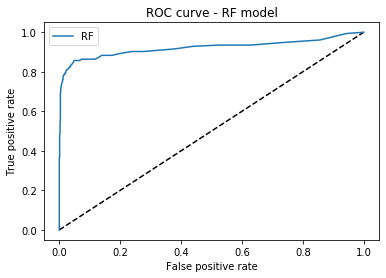

In [0]:
# ROC curve of Random Forest result
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF model')
plt.legend(loc='best')
plt.show()

In [0]:
from sklearn import metrics

# AUC score
metrics.auc(fpr_rf,tpr_rf)

0.9217133339473766

# Part 4: Feature Importance

### Part 4.1:  Random Forest Model - Feature Importance Discussion

In [0]:
# check feature importance of random forest for feature selection
forest = RandomForestClassifier()
forest.fit(X, y)

importances = forest.feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), churn_final.columns), reverse=True):
    print (v + ": " + str(k))

Feature importance ranking by Random Forest Model:
total_day_minutes: 0.2273
number_customer_service_calls: 0.1088
total_eve_minutes: 0.0797
intl_plan: 0.0753
total_intl_minutes: 0.0605
total_intl_calls: 0.0502
total_night_minutes: 0.0495
total_night_charge: 0.0486
account_length: 0.0414
total_day_calls: 0.0404
total_night_calls: 0.0394
total_eve_calls: 0.0384
number_vmail_messages: 0.022
voice_mail_plan: 0.0168
state_TX: 0.0041
state_NJ: 0.0041
state_WA: 0.0039
state_MT: 0.0036
state_MS: 0.0029
state_OH: 0.0027
state_ME: 0.0027
state_WV: 0.0026
state_MN: 0.0026
state_MD: 0.0026
state_NV: 0.0025
state_CA: 0.0025
state_OR: 0.0024
state_UT: 0.0023
state_SC: 0.0022
state_NY: 0.0022
state_DC: 0.0022
state_MI: 0.0021
state_CT: 0.0021
state_AZ: 0.0021
state_AR: 0.0021
state_TN: 0.002
state_MA: 0.002
state_KS: 0.002
state_IN: 0.002
state_ND: 0.0019
state_IL: 0.0018
state_ID: 0.0018
state_DE: 0.0018
state_NC: 0.0017
state_KY: 0.0017
state_WY: 0.0016
state_VA: 0.0016
state_SD: 0.0016
state_CO: 

##Conclusion from feature importance analysis:

Those customers who has intial plan with the company and spend long time on phone calls and prefer calling service center very often, are likely churned users.



##Recommendation for SGI:


*   For those contracted and highly active customers who call service-center frequently, offerring them discount or promotes might be a good way to rescue the potential churn condition. 
*   Pay more attentions to complaints and start a training process to imporve service quality.

##Future work for SGI:


*   Define the most valuable customers by analyzing their main features. Keep maintaining good reputation and impression with those customers and sending them greetings and offers occasionally.
*   Conduct competitor service study and systematically learn and compare with their service strategies.






